<a href="https://colab.research.google.com/github/Ved204/CP468-Facial-Recognition/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Facial Emotion Recognition

Project Configuration

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization

In [3]:
# Mount Drive
from google.colab import drive
import os

drive.mount('/content/drive')
kaggle_json_path = '/content/drive/MyDrive/CP468 Project/kaggle.json'

Mounted at /content/drive


In [ ]:
# Install Dataset
!pip install kaggle
! mkdir ~/.kaggle
! cp {kaggle_json_path} ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d aadityasinghal/facial-expression-dataset
! unzip facial-expression-dataset.zip

# Set File Paths
train_path = '/content/train/train/'
test_path = '/content/test/test/'

In [5]:
# Load Dataset
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [6]:
# Convert training dataset into a dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_path)

# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

# Convert testing dataset into a dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_path)

# Shuffle the dataset
test = test.sample(frac=1).reset_index(drop=True)
test.head()

disgust Completed
happy Completed
sad Completed
neutral Completed
fear Completed
surprise Completed
angry Completed
disgust Completed
happy Completed
sad Completed
neutral Completed
fear Completed
surprise Completed
angry Completed


,image,label
0,/content/test/test/neutral/PrivateTest_7261806...,neutral
1,/content/test/test/neutral/PublicTest_27177058...,neutral
2,/content/test/test/angry/PrivateTest_62110213.jpg,angry
3,/content/test/test/surprise/PrivateTest_634779...,surprise
4,/content/test/test/happy/PrivateTest_42935658.jpg,happy


Data Analysis

<Axes: xlabel='count', ylabel='label'>

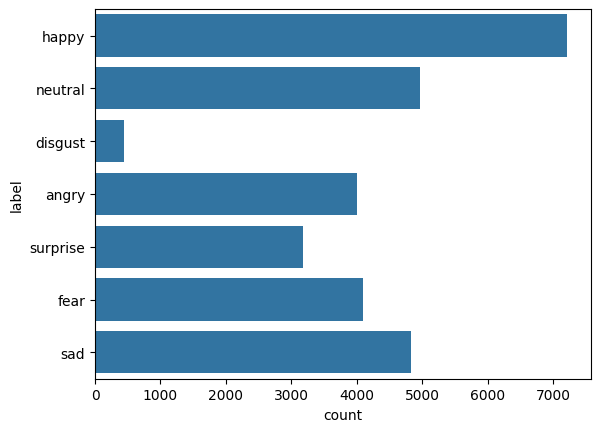

In [7]:
# Plotting Frequency of Labels in training dataset
sns.countplot(train['label'])

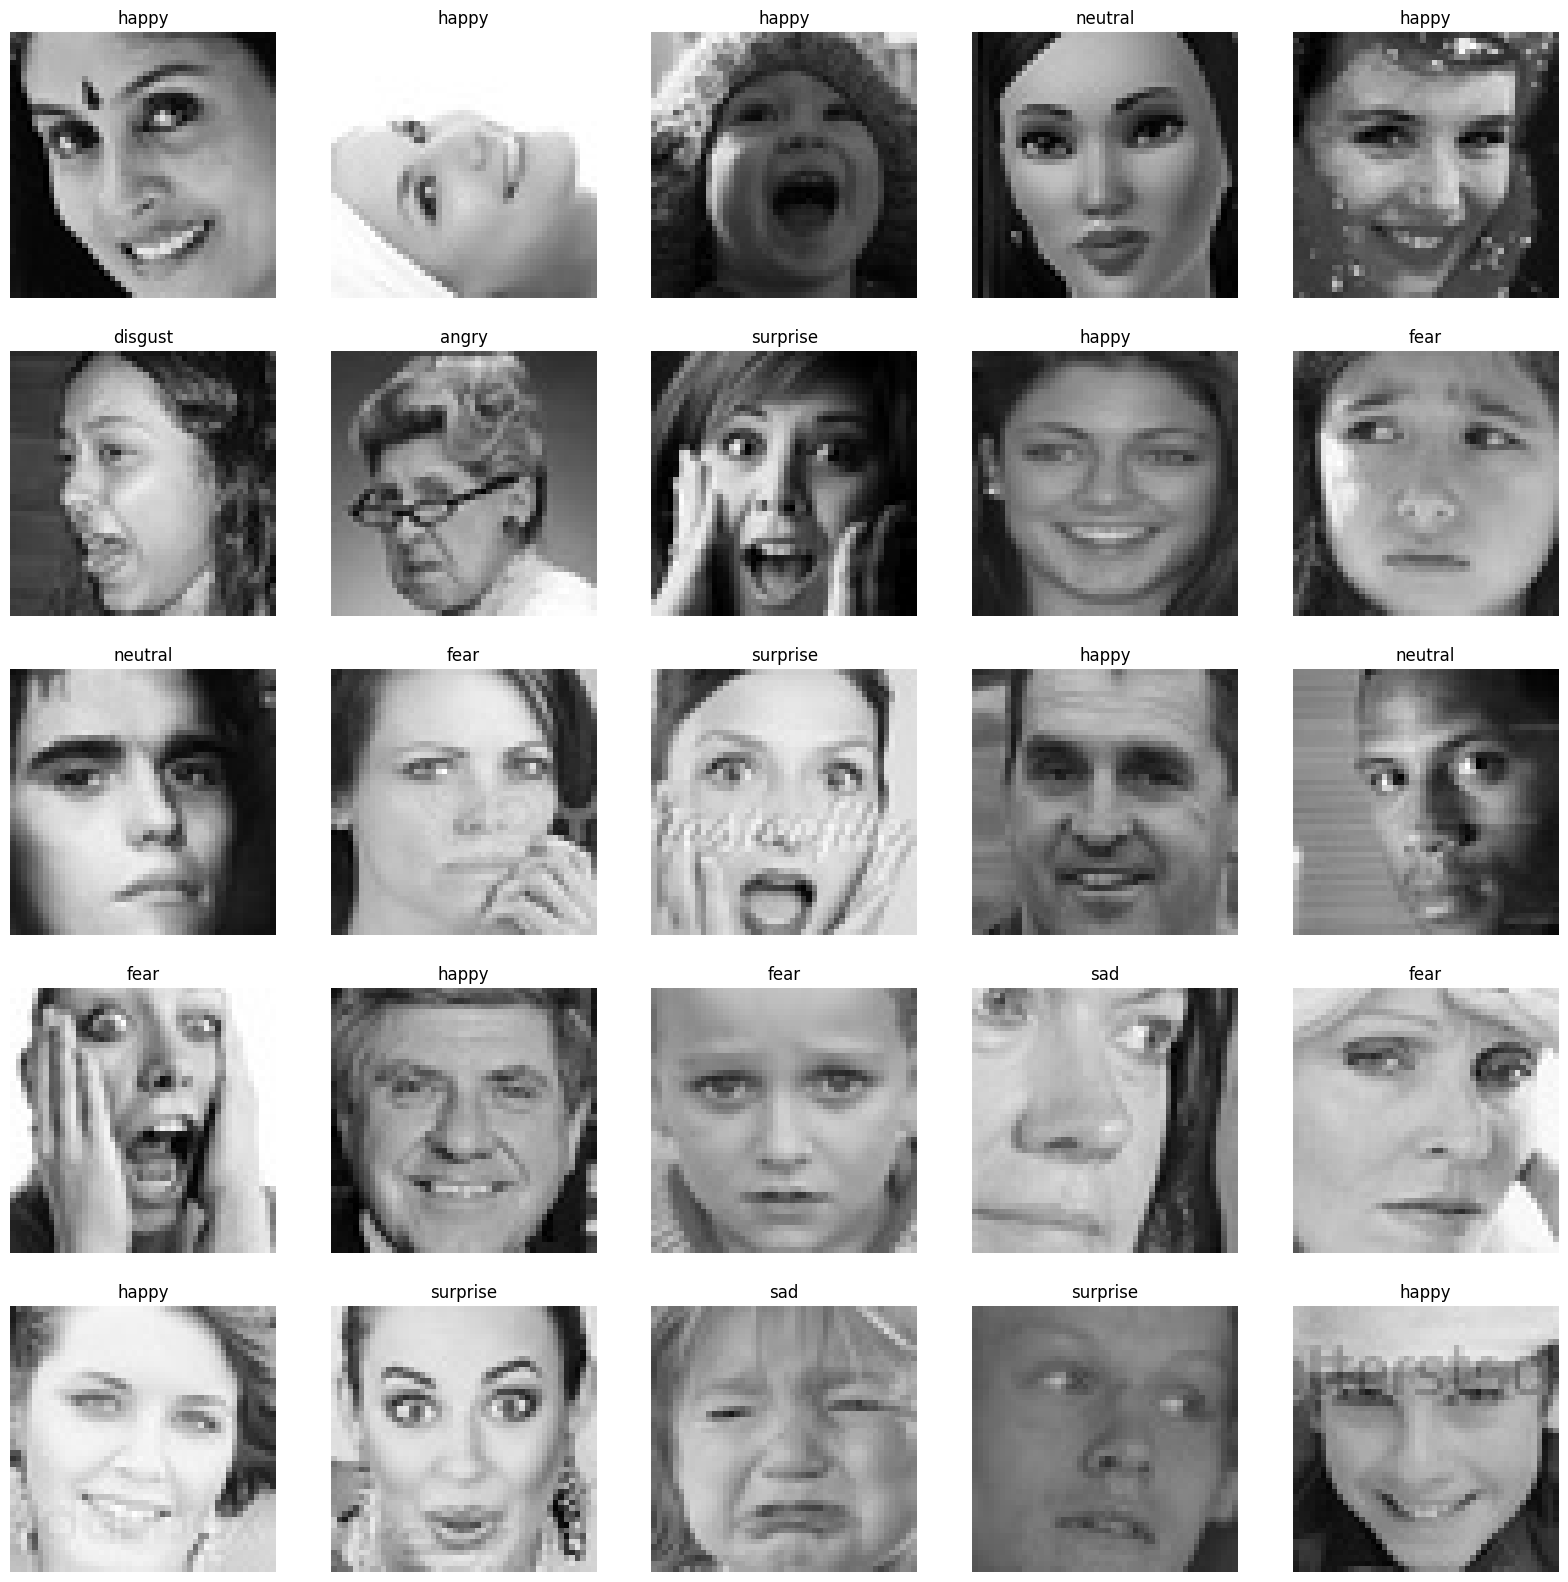

In [8]:
# Sample Images from Training Dataset
from PIL import Image

plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

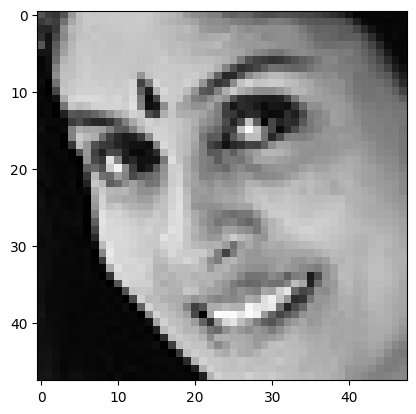

In [9]:
# Show First Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

Feature Extraction

In [10]:
# Extract features from these images to use as input when training CNN
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [11]:
# Extract features for training dataset
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [12]:
# Extract features for testing dataset
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [13]:
# Normalize the Images to improve convergence of CNN
x_train = train_features/255.0
x_test = test_features/255.0

In [14]:
# Transform Training Labels to Integer Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
# Convert the Integer Labels into a Binary Vector
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [16]:
# Seeing how the vector looks like
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

Model Creation

In [17]:
from keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [18]:
# Configuration for Model
input_shape = (48, 48, 1)
output_class = 7

In [19]:
# Defining the Model
model = Sequential()

# Convolutional layers with Batch Normalization
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Flatten Layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# Output Layer using the softmax activation function
model.add(Dense(output_class, activation='softmax'))

In [20]:
# Compile Model with Learning Rate Scheduling
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

# Learning rate schedule
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [140]:
# Train the Model

from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train['label']), y=train['label'])
class_weights = dict(enumerate(class_weights))

# Early Stopping and Model Checkpoint
checkpoint_path = '/content/drive/MyDrive/CP468 Project/model_three/model_checkpoint.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# Train the Model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=100,
    validation_data=(x_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)


Epoch 1/100
225/225 [==============================] - 26s 97ms/step - loss: 2.5289 - accuracy: 0.1513 - val_loss: 1.9140 - val_accuracy: 0.1737 - lr: 0.0010
Epoch 2/100
225/225 [==============================] - 18s 78ms/step - loss: 2.1131 - accuracy: 0.1568 - val_loss: 2.0484 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 3/100
225/225 [==============================] - 21s 92ms/step - loss: 1.9963 - accuracy: 0.1593 - val_loss: 1.8844 - val_accuracy: 0.2531 - lr: 0.0010
Epoch 4/100
225/225 [==============================] - 18s 80ms/step - loss: 1.9461 - accuracy: 0.1666 - val_loss: 1.9243 - val_accuracy: 0.1612 - lr: 0.0010
Epoch 5/100
225/225 [==============================] - 18s 80ms/step - loss: 1.9183 - accuracy: 0.1811 - val_loss: 2.7142 - val_accuracy: 0.1300 - lr: 0.0010
Epoch 6/100
225/225 [==============================] - 19s 83ms/step - loss: 1.8926 - accuracy: 0.1897 - val_loss: 1.9915 - val_accuracy: 0.0829 - lr: 0.0010
Epoch 7/100
225/225 [==============================]

In [168]:
# Save History
import pickle
history_path = '/content/drive/MyDrive/CP468 Project/model_three/history.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Sve Model
save_path = '/content/drive/MyDrive/CP468 Project/model_three/model_final.h5'
model.save(save_path)

Analyze and Plot Results

In [21]:
# Load Model
from keras.models import load_model
import pickle

# Load the saved model
model = load_model('/content/drive/MyDrive/CP468 Project/model_three/model_checkpoint.h5')

# Load the history object
with open('/content/drive/MyDrive/CP468 Project/model_three/history.pkl', 'rb') as file:
    history = pickle.load(file)

# # Continue training the model
# history = model.fit(
#     datagen.flow(x_train, y_train, batch_size=128),
#     epochs=5,
#     validation_data=(x_test, y_test),
#     class_weight=class_weights,
#     callbacks=[early_stopping, checkpoint, lr_scheduler]
# )


# # Merge previous history with new history
# for key in previous_history:
#     previous_history[key].extend(history.history[key])

# # Save the updated history back to file
# with open(history_path, 'wb') as file:
#     pickle.dump(previous_history, file)


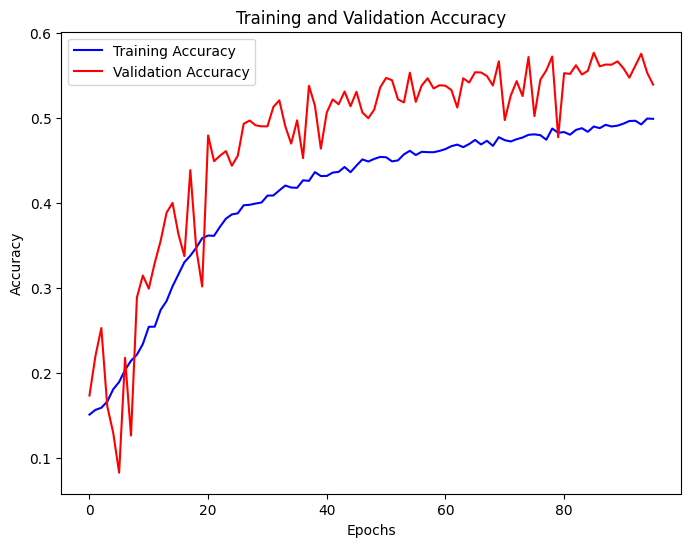

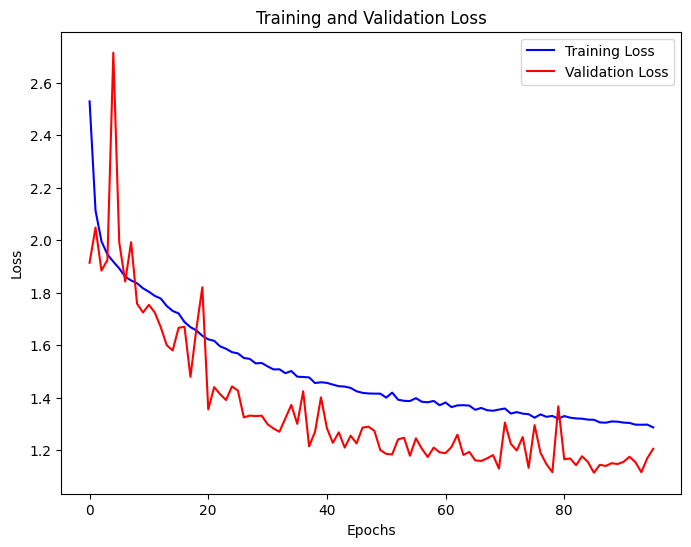

225/225 [==============================] - 32s 138ms/step


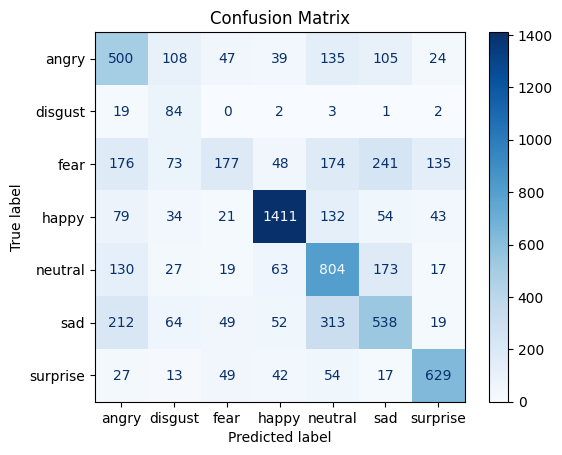

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Accuracy and Loss Graph with Axis Labels
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

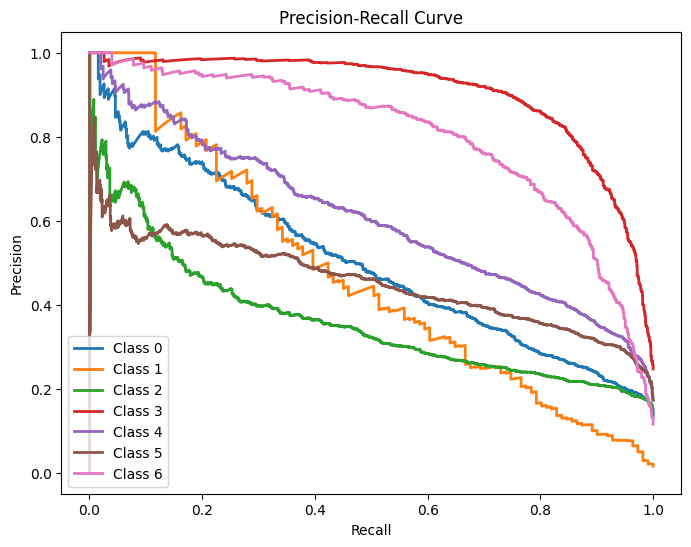

In [23]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()
for i in range(output_class):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])

plt.figure(figsize=(8, 6))
for i in range(output_class):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


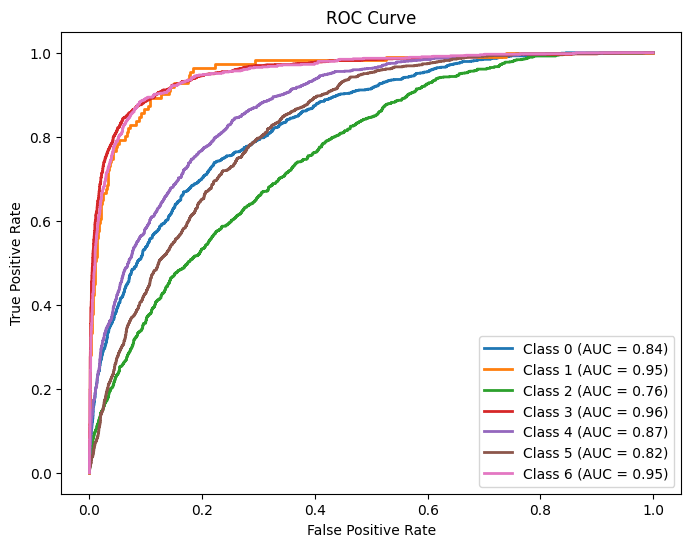

In [24]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(output_class):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()


In [25]:
# Classification Report
from sklearn.metrics import classification_report

# Evaluate on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

# Predict on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_classes))


225/225 [==============================] - 23s 100ms/step - loss: 1.1144 - accuracy: 0.5772
Test Loss: 1.1144332885742188, Test Accuracy: 0.5771802663803101
225/225 [==============================] - 37s 165ms/step
              precision    recall  f1-score   support

           0       0.44      0.52      0.48       958
           1       0.21      0.76      0.33       111
           2       0.49      0.17      0.26      1024
           3       0.85      0.80      0.82      1774
           4       0.50      0.65      0.56      1233
           5       0.48      0.43      0.45      1247
           6       0.72      0.76      0.74       831

    accuracy                           0.58      7178
   macro avg       0.53      0.58      0.52      7178
weighted avg       0.59      0.58      0.57      7178



Testing Model

Original Output: angry
1/1 [==============================] - 0s 27ms/step
Predicted Output: disgust


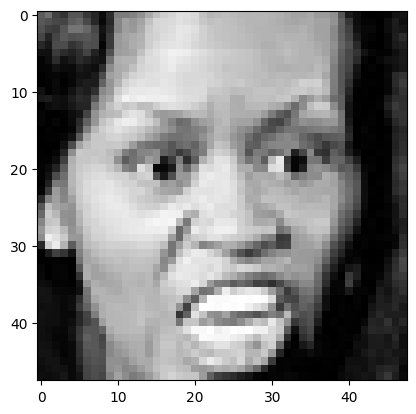

In [29]:
# Test 1 with Random Image
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happy
1/1 [==============================] - 0s 37ms/step
Predicted Output: angry


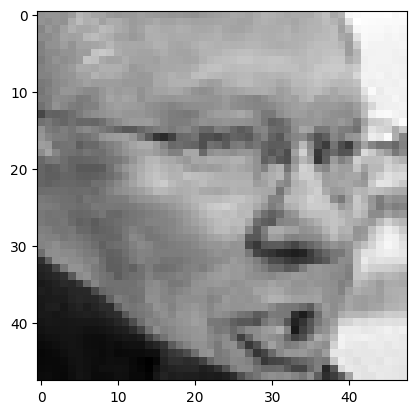

In [30]:
# Test 2 with Random Image
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: surprise
1/1 [==============================] - 0s 30ms/step
Predicted Output: surprise


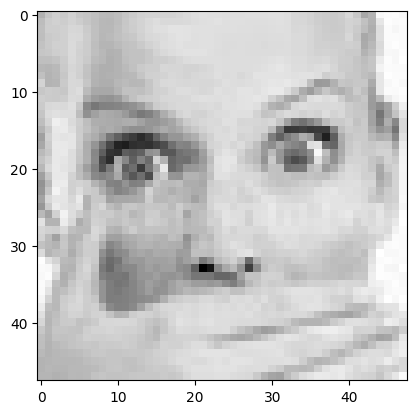

In [28]:
# Test 3 with Random Image
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: sad
1/1 [==============================] - 0s 112ms/step
Predicted Output: sad


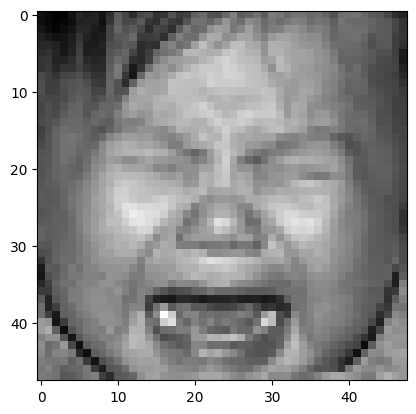

In [31]:
# Test 4 with Random Image
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: sad
1/1 [==============================] - 0s 38ms/step
Predicted Output: neutral


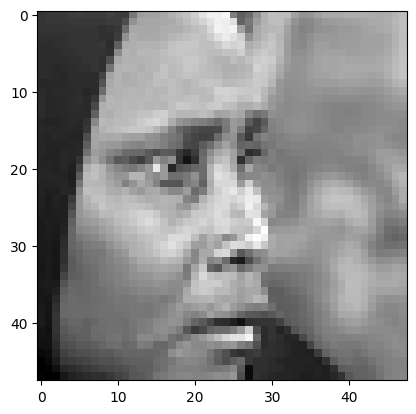

In [32]:
# Test 5 with Random Image
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');